# 稳健回归

稳健回归（Robustness regression）: 处理离群点（outliers）和模型错误
稳健回归（robust regression）特别适用于回归模型包含损坏数据（corrupt data）的情况，如离群点或模型中的错误。

它的目标是减小异常值对回归模型的影响，提高模型对数据的鲁棒性。

传统的最小二乘线性回归对异常值非常敏感，即使有一个离群点，也可能导致拟合的直线或曲线产生较大的偏移。而稳健回归通过使用鲁棒估计方法来降低这种影响。

下面介绍参考[1]

## 离群值

对于离群值需要考虑

1. 是在X方向还是Y方向

![](../../images/outlier/outliers_x_y.png)

2. 数据值是大还是小

![](../../images/outlier/outliers_small_large.png)

## RANSAC

随机抽样一致性算法（Random Sample Consensus，RANSAC），算法步骤如下：

* 随机选择样本：从数据集中随机选择一小部分样本作为内点集。

* 拟合模型：使用选定的内点集来拟合一个模型，例如线性回归。

* 内点检验：对于剩余的数据点，计算它们与模型之间的距离。如果某个数据点与模型的距离小于阈值，则将其视为内点，否则将其视为外点。

* 评估模型：统计符合模型的内点数量。如果内点数量超过预设的阈值，则认为当前模型是拟合良好的模型。

* 重复迭代：通过多次重复上述步骤，每次选择不同的随机子集，并选择具有最大内点数的模型作为最终模型。

* 重新拟合最终模型：使用所有被标记为内点的数据点重新拟合最终模型。

Estimated coefficients (true, linear regression, RANSAC):
82.1903908407869 [54.17236387] [82.08533159]


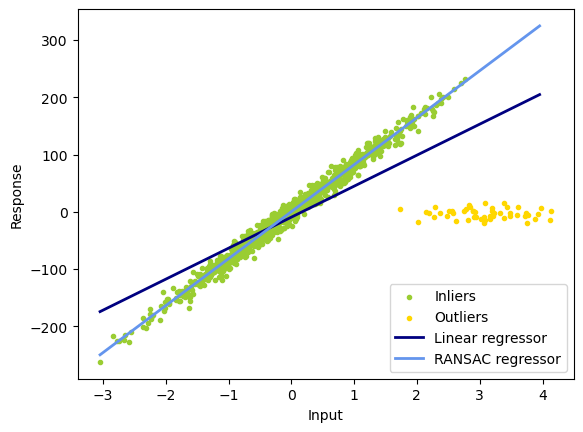

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn import datasets, linear_model

n_samples = 1000
n_outliers = 50

# 生成带有离群点的数据集
X, y, coef = datasets.make_regression(
    n_samples=n_samples,
    n_features=1,
    n_informative=1,
    noise=10,
    coef=True,
    random_state=0,
)

# 添加离群点数据
np.random.seed(0)
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

# 使用所有数据拟合线性模型
lr = linear_model.LinearRegression()
lr.fit(X, y)

# 使用RANSAC算法稳健地拟合线性模型
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# 预测估计模型的数据
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

# 比较估计的系数
print("Estimated coefficients (true, linear regression, RANSAC):")
print(coef, lr.coef_, ransac.estimator_.coef_)

lw = 2
plt.scatter(
    X[inlier_mask], y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
)
plt.scatter(
    X[outlier_mask], y[outlier_mask], color="gold", marker=".", label="Outliers"
)
plt.plot(line_X, line_y, color="navy", linewidth=lw, label="Linear regressor")
plt.plot(
    line_X,
    line_y_ransac,
    color="cornflowerblue",
    linewidth=lw,
    label="RANSAC regressor",
)
plt.legend(loc="lower right")
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

## Theil-Sen

Theil-Sen预估器是一种广义中值估计器（generalized-median-based estimator）。它用于拟合数据，并通过中位数来估计模型的参数。工作原理如下：

* 数据集：假设我们有一个包含n个数据点的数据集：$D = {(x_1, y_1), (x_2, y_2), …, (x_n, y_n)}$，其中$x_i$是自变量，$y_i$是因变量。

* 斜率选择：对于每对数据点$(x_i, y_i)和(x_j, y_j)$，计算斜率$s = (y_j - y_i) / (x_j - x_i)$。然后，从这些**斜率中选择中位数**作为初始的斜率估计。

* 中位数迭代：通过迭代的方式来寻找最佳的斜率估计。在每次迭代中，计算每对数据点的斜率，然后将这些斜率排序并选择中位数。使用中位数来更新当前的斜率估计。

* 最终参数估计：在达到指定的迭代次数或收敛准则之后，得到最终的斜率估计。然后，可以使用该斜率估计来计算截距。

下面看下，Theil-Sen对y向和x向离群值的处理效果：

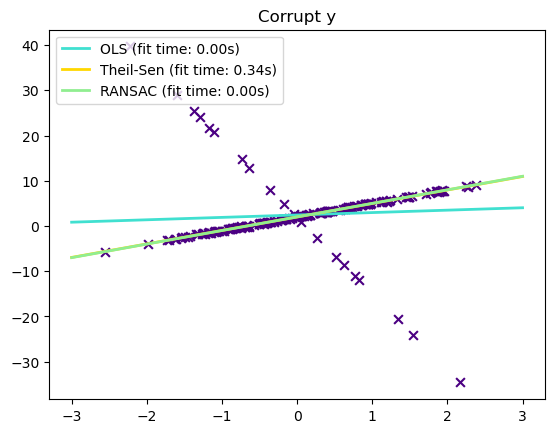

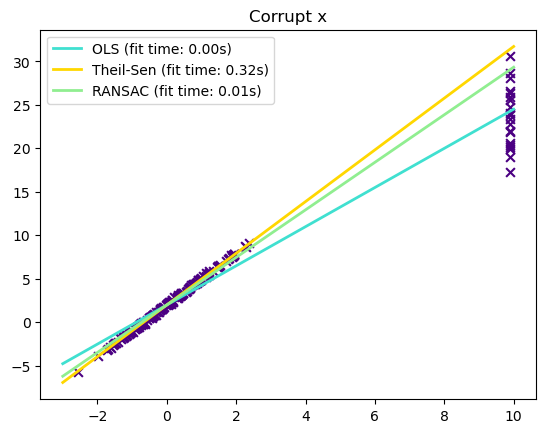

In [6]:
import time

import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression, RANSACRegressor, TheilSenRegressor

estimators = [
    ("OLS", LinearRegression()),
    ("Theil-Sen", TheilSenRegressor(random_state=42)),
    ("RANSAC", RANSACRegressor(random_state=42)),
]
colors = {"OLS": "turquoise", "Theil-Sen": "gold", "RANSAC": "lightgreen"}
lw = 2

np.random.seed(0)
n_samples = 200
# Linear model y = 3*x + N(2, 0.1**2)
x = np.random.randn(n_samples)
w = 3.0
c = 2.0
noise = 0.1 * np.random.randn(n_samples)
y = w * x + c + noise
# 10% outliers
y[-20:] += -20 * x[-20:]
X = x[:, np.newaxis]

plt.scatter(x, y, color="indigo", marker="x", s=40)
line_x = np.array([-3, 3])
for name, estimator in estimators:
    t0 = time.time()
    estimator.fit(X, y)
    elapsed_time = time.time() - t0
    y_pred = estimator.predict(line_x.reshape(2, 1))
    plt.plot(
        line_x,
        y_pred,
        color=colors[name],
        linewidth=lw,
        label="%s (fit time: %.2fs)" % (name, elapsed_time),
    )

plt.axis("tight")
plt.legend(loc="upper left")
_ = plt.title("Corrupt y")


np.random.seed(0)
# Linear model y = 3*x + N(2, 0.1**2)
x = np.random.randn(n_samples)
noise = 0.1 * np.random.randn(n_samples)
y = 3 * x + 2 + noise
# 10% outliers
x[-20:] = 9.9
y[-20:] += 22
X = x[:, np.newaxis]

plt.figure()
plt.scatter(x, y, color="indigo", marker="x", s=40)

line_x = np.array([-3, 10])
for name, estimator in estimators:
    t0 = time.time()
    estimator.fit(X, y)
    elapsed_time = time.time() - t0
    y_pred = estimator.predict(line_x.reshape(2, 1))
    plt.plot(
        line_x,
        y_pred,
        color=colors[name],
        linewidth=lw,
        label="%s (fit time: %.2fs)" % (name, elapsed_time),
    )

plt.axis("tight")
plt.legend(loc="upper left")
plt.title("Corrupt x")
plt.show()

## Hurber回归

HuberRegressor与Ridge不同，因为它对被视为异常值的样本应用了一个线性损失函数。如果某个样本的绝对误差小于某一阈值（epsilon），则该样本被视为内围值。

HuberRegressor最小化的损失函数为：
$
\underset{w, \sigma}{min} \sum_{i=1}^n\left(\sigma + H_m\left(\frac{X_{i}w - y_{i}}{\sigma}\right)\sigma\right) + \alpha ||w||_2^2
$

其中，
$
H_m(z) = \begin{cases}
z^2, & |z| < \epsilon \\
2\epsilon|z| - \epsilon^2, & \text{否则}
\end{cases}
$

这里的 $w$ 是模型的参数，$σ$ 是样本的标准差，$X_i$ 是自变量，$y_i$ 是因变量，n是样本数量，$α$ 是正则化参数，$ε$ 是阈值。

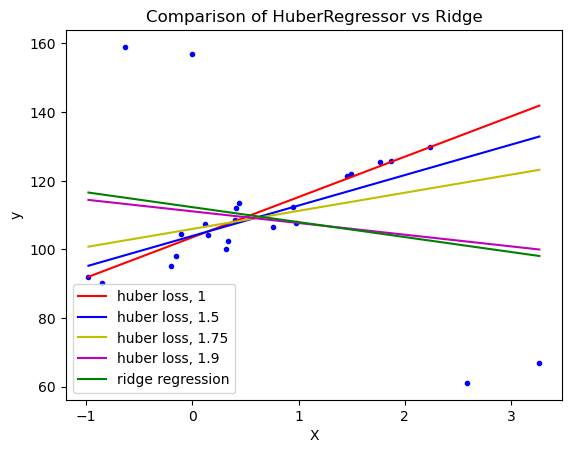

In [8]:
# Authors: Manoj Kumar mks542@nyu.edu
# License: BSD 3 clause
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_regression
from sklearn.linear_model import HuberRegressor, Ridge

# 生成示例数据
rng = np.random.RandomState(0)
X, y = make_regression(
    n_samples=20, n_features=1, random_state=0, noise=4.0, bias=100.0
)

# 向数据集添加四个强离群点
X_outliers = rng.normal(0, 0.5, size=(4, 1))
y_outliers = rng.normal(0, 2.0, size=4)
X_outliers[:2, :] += X.max() + X.mean() / 4.0
X_outliers[2:, :] += X.min() - X.mean() / 4.0
y_outliers[:2] += y.min() - y.mean() / 4.0
y_outliers[2:] += y.max() + y.mean() / 4.0
X = np.vstack((X, X_outliers))
y = np.concatenate((y, y_outliers))
plt.plot(X, y, "b.")

# 使用一系列epsilon值拟合Huber回归器
colors = ["r-", "b-", "y-", "m-"]

x = np.linspace(X.min(), X.max(), 7)
epsilon_values = [1, 1.5, 1.75, 1.9]
for k, epsilon in enumerate(epsilon_values):
    huber = HuberRegressor(alpha=0.0, epsilon=epsilon)
    huber.fit(X, y)
    coef_ = huber.coef_ * x + huber.intercept_
    plt.plot(x, coef_, colors[k], label="huber loss, %s" % epsilon)

# 使用岭回归器进行比较
ridge = Ridge(alpha=0.0, random_state=0)
ridge.fit(X, y)
coef_ridge = ridge.coef_
coef_ = ridge.coef_ * x + ridge.intercept_
plt.plot(x, coef_, "g-", label="ridge regression")

plt.title("Comparison of HuberRegressor vs Ridge")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()

根据数据的特点和对异常值的处理需求，选择适当的鲁棒回归估计器。
* 如果需要更高的鲁棒性并且样本较小，可以考虑使用HuberRegressor。
* 如果需要处理大的y方向离群值，可以使用RANSAC。
* 如果需要处理中等大小的x方向离群值，并且不是高维情况，可以考虑Theil Sen。

## 参考：

* [1] sklearn 稳健回归 https://scikit-learn.org/stable/modules/linear_model.html#quantile-regression